# Object Detection using Conventional Neural Networks (CNNs)
### - classification of images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).
### - The dataset consists of airplanes, dogs, cats, cars etc. A total of 10 different classes.

We data is preprocessed on the images, then trained a convolutional neural network on all the samples. The images are normalized and the labels one-hot encoded including max pooling, dropout, and fully connected layers at the end of the network.

![cnn](cnn.png)

# Downloading the dataset
### Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [15:27, 184KB/s]                                


All files found!


## Explore the Data
The dataset is broken into batches to prevent machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


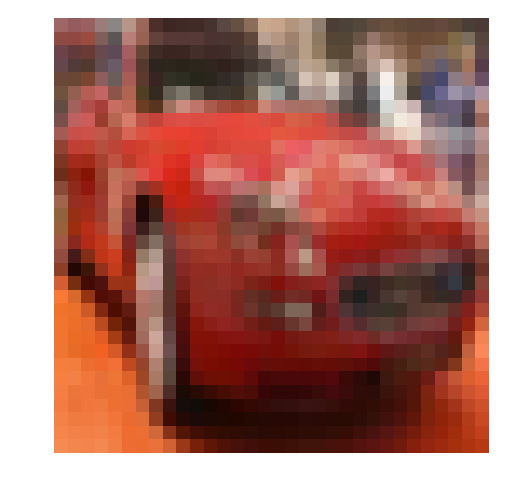

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Looking at the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implementing Preprocess Functions
### Normalization

In [3]:
def normalize(x):
    """
    Normalizing a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : returns: Numpy array of normalize data
    """
    ranges = np.max(x) - np.min(x)
    return (x - np.min(x)) / ranges

Tests Passed


### One-hot encoding

In [12]:
def one_hot_encode(x):
    """
    One hot encoding a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    new_label = np.zeros((len(x), 10))
    for i in range(len(x)):
        new_label[i, x[i]] = 1
    return new_label

Tests Passed


### Randomizing Data
As we saw from exploring the data above, the order of the samples are randomized already.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [13]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## creating checkpoint 1

In [14]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we have build each layer into a function.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [24]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape = (None, *image_shape), name = 'x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. Below we have implemented the function `conv2d_maxpool` to apply convolution then max pooling.

In [25]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], x_tensor.shape[3].value, conv_num_outputs], mean=0, stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    convolution_layer = tf.nn.conv2d( x_tensor, weight, strides = [1, conv_strides[0], conv_strides[1], 1], padding = 'SAME')
    
    convolution_layer = tf.nn.bias_add(convolution_layer, bias)
    
    convolution_layer = tf.nn.relu(convolution_layer)
                          
    final_layer = tf.nn.max_pool(convolution_layer, ksize = [1, pool_ksize[0], pool_ksize[1], 1], strides = [1, pool_strides[0], pool_strides[1], 1], padding='SAME')

    return final_layer

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*).

In [27]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.contrib.layers.flatten(x_tensor)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [29]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], mean = 0, stddev = 0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    hidden_layer = tf.matmul(x_tensor, weight)

    hidden_layer = tf.nn.bias_add(hidden_layer, bias)

    hidden_layer = tf.nn.relu(hidden_layer)
   
    return hidden_layer

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

**Note:** Activation, softmax, or cross entropy is **not** applied to this.

In [30]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], mean = 0, stddev = 0.1))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    output_layer = tf.matmul(x_tensor, weight)

    output_layer = tf.nn.bias_add(output_layer, bias)

    output_layer = tf.nn.relu(output_layer)
   
    return output_layer

Tests Passed


### Create Convolutional Model
Implementing a function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.

#### We have applied :
* 3 Convolution and Max Pool layers
* a Flatten Layer
* 3 Fully Connected Layers
* an Output Layer
* Applied TensorFlow's Dropout to one or more layers in the model using `keep_prob`. 

finally returning the output

In [36]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # 3 Convolution and Max Pool layers
    conv_layers = conv2d_maxpool(x, 16, (3, 3), (1, 1), (2, 2), (2, 2))
    conv_layers = conv2d_maxpool(x, 32, (3, 3), (2, 2), (2, 2), (2, 2))
    conv_layers = conv2d_maxpool(x, 64, (3, 3), (1, 1), (2, 2), (2, 2))


    # Apply a Flatten Layer
    conv_layers = flatten(conv_layers)
    

    # 3 Fully Connected Layers
    conv_layers = fully_conn(conv_layers, 100)
    conv_layers = tf.nn.dropout(conv_layers, keep_prob)
    conv_layers = fully_conn(conv_layers, 50)
    conv_layers = tf.nn.dropout(conv_layers, keep_prob)
    
    # Apply an Output Layer
    answer = output(conv_layers, 10)

    # return output
    return answer

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Neural Network Built!


## Hyper parameter tuning using small dataset
### Single Optimization
Implemented the function `train_neural_network` to do a single optimization.

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note:This function is only optimizing the neural network.

In [37]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimizing the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict = { x: feature_batch, y: label_batch, keep_prob: keep_probability })

Tests Passed


### See Stats

In [38]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict = {x: feature_batch, y: label_batch, keep_prob: 1} )
    val_accu = session.run(accuracy, feed_dict = {x: valid_features, y: valid_labels, keep_prob: 1})
    
    print('loss: {:>10.4f} validation accuracy: {:.6f}'.format(loss, val_accu))

Tune the following parameters:
* Setting `epochs` to the number of iterations until the network stops learning or starts overfitting.
* Setting `batch_size` to the highest number that the machine has memory for.
* Setting `keep_probability` to the probability of keeping a node using dropout

In [44]:
epochs = 37
batch_size = 256
keep_probability = 0.7

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while iterating on the complete model to get a better accuracy.

In [40]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  loss:     2.1758 validation accuracy: 0.250800
Epoch  2, CIFAR-10 Batch 1:  loss:     1.9337 validation accuracy: 0.346800
Epoch  3, CIFAR-10 Batch 1:  loss:     1.8091 validation accuracy: 0.400200
Epoch  4, CIFAR-10 Batch 1:  loss:     1.6210 validation accuracy: 0.435800
Epoch  5, CIFAR-10 Batch 1:  loss:     1.4904 validation accuracy: 0.450800
Epoch  6, CIFAR-10 Batch 1:  loss:     1.3298 validation accuracy: 0.459800
Epoch  7, CIFAR-10 Batch 1:  loss:     1.2193 validation accuracy: 0.485800
Epoch  8, CIFAR-10 Batch 1:  loss:     1.0756 validation accuracy: 0.486400
Epoch  9, CIFAR-10 Batch 1:  loss:     1.0094 validation accuracy: 0.498200
Epoch 10, CIFAR-10 Batch 1:  loss:     0.9311 validation accuracy: 0.492800
Epoch 11, CIFAR-10 Batch 1:  loss:     0.8195 validation accuracy: 0.502800
Epoch 12, CIFAR-10 Batch 1:  loss:     0.7360 validation accuracy: 0.507400
Epoch 13, CIFAR-10 Batch 1:  loss:     0.6720

### Fully Training the Model
Now that we have got a good accuracy with a single CIFAR-10 batch, lets try it with all five batches.

In [41]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  loss:     2.1742 validation accuracy: 0.282200
Epoch  1, CIFAR-10 Batch 2:  loss:     1.9105 validation accuracy: 0.337000
Epoch  1, CIFAR-10 Batch 3:  loss:     1.6542 validation accuracy: 0.365800
Epoch  1, CIFAR-10 Batch 4:  loss:     1.6884 validation accuracy: 0.391800
Epoch  1, CIFAR-10 Batch 5:  loss:     1.6161 validation accuracy: 0.425200
Epoch  2, CIFAR-10 Batch 1:  loss:     1.7458 validation accuracy: 0.442600
Epoch  2, CIFAR-10 Batch 2:  loss:     1.4426 validation accuracy: 0.449000
Epoch  2, CIFAR-10 Batch 3:  loss:     1.2608 validation accuracy: 0.467600
Epoch  2, CIFAR-10 Batch 4:  loss:     1.3819 validation accuracy: 0.491800
Epoch  2, CIFAR-10 Batch 5:  loss:     1.3130 validation accuracy: 0.499000
Epoch  3, CIFAR-10 Batch 1:  loss:     1.4517 validation accuracy: 0.508600
Epoch  3, CIFAR-10 Batch 2:  loss:     1.1943 validation accuracy: 0.494600
Epoch  3, CIFAR-10 Batch 3:  loss:     1.0232 validation accuracy: 0.504400


Epoch 22, CIFAR-10 Batch 4:  loss:     0.1818 validation accuracy: 0.643600
Epoch 22, CIFAR-10 Batch 5:  loss:     0.1814 validation accuracy: 0.650800
Epoch 23, CIFAR-10 Batch 1:  loss:     0.2106 validation accuracy: 0.649800
Epoch 23, CIFAR-10 Batch 2:  loss:     0.1464 validation accuracy: 0.634800
Epoch 23, CIFAR-10 Batch 3:  loss:     0.1395 validation accuracy: 0.646200
Epoch 23, CIFAR-10 Batch 4:  loss:     0.1845 validation accuracy: 0.637600
Epoch 23, CIFAR-10 Batch 5:  loss:     0.1489 validation accuracy: 0.640200
Epoch 24, CIFAR-10 Batch 1:  loss:     0.2339 validation accuracy: 0.639800
Epoch 24, CIFAR-10 Batch 2:  loss:     0.1395 validation accuracy: 0.646600
Epoch 24, CIFAR-10 Batch 3:  loss:     0.1348 validation accuracy: 0.650800
Epoch 24, CIFAR-10 Batch 4:  loss:     0.1714 validation accuracy: 0.631400
Epoch 24, CIFAR-10 Batch 5:  loss:     0.1472 validation accuracy: 0.651800
Epoch 25, CIFAR-10 Batch 1:  loss:     0.1905 validation accuracy: 0.652600
Epoch 25, CI

## Checkpoint 2
The model has been saved to disk.

# Testing the Model
Testing model against the test dataset.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.630859375



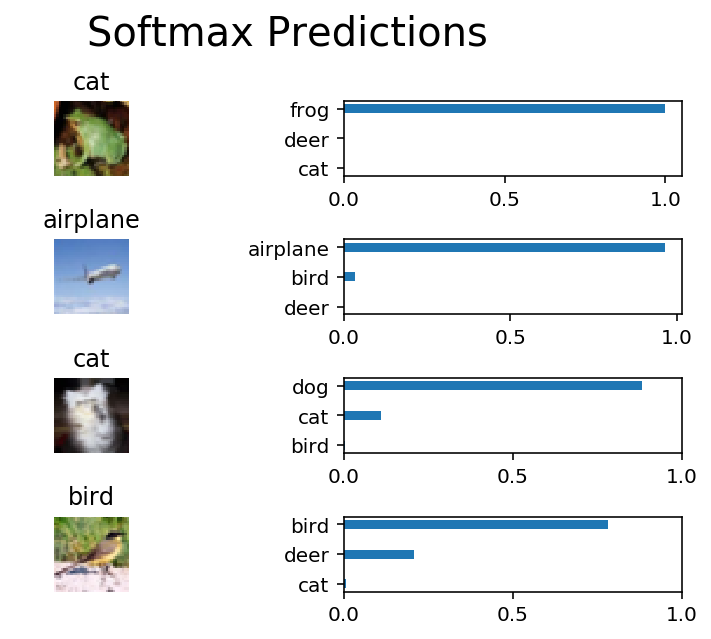

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

#### We can increase this CNNs prediction utpo 80% and more by using more layers of convolution and fully connected layers, which will significantly increase the time it takes to train and so a GPU is a must. Therefore the model is kept quite simple and fast to be trained using a CPU. 